In [1]:
from PIL import Image
import cv2 
import numpy as np
import glob
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
%matplotlib inline

In [2]:
img_list = glob.glob("paris_train_original.nosync/*.JPG")

In [3]:
def get_imgs(loc ,ext ,to_file = 0):
    loc = glob.glob(f"{loc}/*.{ext}")[:100]
    images = []
    for img_loc in loc:
        pil_img = Image.open(img_loc)
        pil_img.draft('RGB',(227,227))
        pil_img = pil_img.resize((227,227))
        images.append(np.asarray(pil_img))        
    images = np.array(images)
    return images

In [4]:
train_loc = "paris_train_original.nosync"
images = get_imgs(train_loc,'JPG')

test_loc = "paris_eval.nosync/paris_eval_gt"
test_images = get_imgs(test_loc,'png')

In [5]:
upper = [np.random.randint(0,537), np.random.randint(0,936)] 
lower = [np.random.randint(upper[0],537), np.random.randint(upper[1],936)] 



In [6]:
images[0][upper[0]:lower[0],upper[1]:lower[1]] = 255

In [7]:
plt.imshow(train_images[72])

NameError: name 'train_images' is not defined

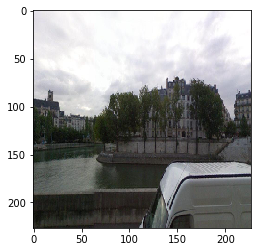

In [8]:
 plt.imshow(images[72])

In [9]:
# TO FIX
# overlaps
# not exactly 25%
# Squares can differ in sizes 
def cover_percentage(img,cover):
    img = img.copy()
    shape = img.shape
    corner = [(shape[0]-cover[0])//2,(shape[1]-cover[1])//2]
    img[corner[0]:cover[0]+corner[0],corner[1]:cover[1]+corner[1]] = 255 
    img_perc_covered = img.flatten()
    img_perc_covered = np.count_nonzero( img_perc_covered == 255) / img_perc_covered.shape[0]
    print(img_perc_covered*100)
    return img
            
            

7.96056589493295


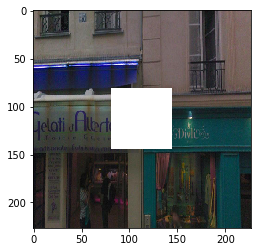

In [10]:
plt.imshow(cover_percentage(images[22],(64,64)))


# Data Formatting for pytorch + Train Test Split

In [11]:
class ToFillDataset_train(Dataset):
    def __init__(self, images, corrupted_images=None):
        self.images = images
        self.corrupted_images = corrupted_images
        
    def corrupt_image(self, img):
        img = img.copy()
        cropped_info = []
        for i in range(9):
            img_perc_covered = img.flatten()
            img_perc_covered = np.count_nonzero( img_perc_covered == 255) / img_perc_covered.shape[0]
            if(img_perc_covered < 0.25):
                cover = [40,40]
                corner = [np.random.randint(0,227-cover[0]), np.random.randint(0,227-cover[1])] 
                img[corner[0]:cover[0]+corner[0],corner[1]:cover[1]+corner[1]] = 255
                point = (corner[0],cover[0]+corner[0],corner[1],cover[1]+corner[1])
                cropped_info.append(corner)
            else:
                img_perc_covered = img.flatten()
                break
        
        
        return img, cropped_info 
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        image = self.images[item]
        
        if type(self.corrupted_images) == int :
            corrupt_images, cropped_info = self.corrupt_image(self.images[item])
        else:
            corrupt_images = self.corrupted_images[item]
            
        
        return {
          'image': image,
          'corrupt_image': corrupt_images ,
          'cropped_info': cropped_info 
        }

In [12]:
def create_data_loader(images ,corrupt_images = 0 ):
    ds = ToFillDataset_train(images, corrupt_images)
    return DataLoader(ds, batch_size = 2) 

In [13]:
train = create_data_loader(images)

In [14]:
training_data_loaded = next(iter(train))

In [15]:
 training_data_loaded["cropped_info"]

[[tensor([184, 184]), tensor([128,  65])],
 [tensor([102, 135]), tensor([153, 112])],
 [tensor([98, 71]), tensor([65, 99])],
 [tensor([114, 153]), tensor([162, 172])],
 [tensor([165,   5]), tensor([ 76, 154])],
 [tensor([52, 53]), tensor([ 28, 101])],
 [tensor([182,  63]), tensor([137,   5])],
 [tensor([173, 137]), tensor([169,  45])],
 [tensor([76, 24]), tensor([ 74, 169])]]

In [21]:
image_test = training_data_loaded["image"][1]
print(image_test.shape)
image_test = torch.reshape(image_test,(3,227,227))
image_test = torch.reshape(image_test,(227,227,3))

torch.Size([227, 227, 3])


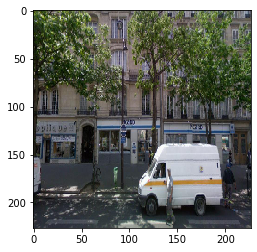

In [22]:
plt.imshow(training_data_loaded["image"][1])

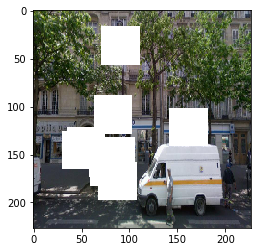

In [131]:
plt.imshow(training_data_loaded["corrupt_image"][1])

In [ ]:
test_images_loc = glob.glob("paris_eval.nosync/paris_eval_gt/*.png")

In [ ]:
test_images_corrupt_loc = glob.glob("paris_eval.nosync/paris_eval_corrupted/*.png")

In [ ]:
test_images = []
for i in test_images_loc:
    pil_img = Image.open(i).convert('RGB')
    pil_img = np.array(pil_img)
    test_images.append(pil_img)
    
test_images = np.array(test_images)
test_images.shape

In [ ]:
test_images_corrupt = []
for i in test_images_corrupt_loc:
    pil_img = Image.open(i).convert('RGB')
    pil_img = np.array(pil_img)
    test_images_corrupt.append(pil_img)
    
test_images_corrupt = np.array(test_images_corrupt)
test_images_corrupt.shape

In [ ]:
test = create_data_loader(test_images,test_images_corrupt)

In [ ]:
testing_data_loaded = next(iter(test))

In [ ]:
plt.imshow(testing_data_loaded["image"][10])

In [ ]:
plt.imshow(testing_data_loaded["corrupt_image"][10])

In [ ]:
img_list[:9]

In [ ]:
i = img_list[9]

In [ ]:
i[25:]

In [ ]:
glob.glob("paris*/*/")

In [ ]:
from torch import nn


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16 
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 128 x 128
            nn.Tanh()
            
        )
    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16 
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # state size. 1
        )
    def forward(self, input):
        return self.main(input)

In [ ]:
    # Number of channels in the training images. For color images this is 3
    nc = 3
    # Size of z latent vector (i.e. size of generator input)
    nz = 100
    # Size of feature maps in generator
    ngf = 227
    # Size of feature maps in discriminator
    ndf = 227
Generator(0)

In [ ]:
strides = (1,1)
in_height = 227
in_width = 227
kernel_size = (5,5)
padding_height = 1
padding_width = 1
out_height = strides[0] * (in_height - 1) + kernel_size[0] - 2 * padding_height
out_width  = strides[1] * (in_width - 1) + kernel_size[1] - 2 * padding_width
(out_height, out_width)

In [ ]:
images = training_data_loaded["image"]

In [ ]:
images = torch.reshape(images,(16,227,227,3))

In [ ]:
images.shape

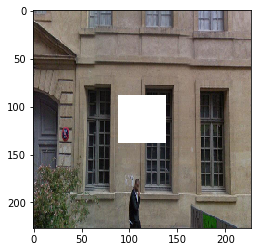

In [130]:
size = 50
mid = (227-size)//2 + 1
corner = (mid,mid)
cover = (size,size)
image = images[20].copy()
image[corner[0]:cover[0]+corner[0],corner[1]:cover[1]+corner[1]] = 255
plt.imshow(image)

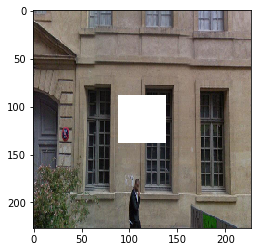

In [129]:
plt.imshow(image)